In [1]:
import numpy as np
import warnings
from hdf5storage import loadmat,savemat
from matplotlib import pyplot as plt
from scipy.stats import sem
import networkx as nx

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# load condition_all
outdict=loadmat('mean30f_sem30f_2syn_4condi.mat')
mean30f_syn_4condi=outdict["mean30f_syn_4condi"]
sem30f_syn_4condi=outdict["sem30f_syn_4condi"]

In [3]:
# function for printing figures into Pdf file
# https://www.geeksforgeeks.org/save-multiple-matplotlib-figures-in-single-pdf-file-using-python/
from matplotlib.backends.backend_pdf import PdfPages

def save_image(filename):
    
    # PdfPages is a wrapper around pdf 
    # file so there is no clash and
    # create files with no error.
    p = PdfPages(filename)
      
    # get_fignums Return list of existing
    # figure numbers
    fig_nums = plt.get_fignums()  
    figs = [plt.figure(n) for n in fig_nums]
      
    # iterating over the numbers in list
    for fig in figs: 
        
        # and saving the files
        fig.savefig(p, format='pdf') 
          
    # close the object
    p.close()  



In [4]:
# construct edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [5]:
# load chan locs for topoplots
dict_loc=loadmat('../Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']

In [6]:
syn2names=['synch','synco']
states4names=['Uncoupled','Leading','Following','Mutual']
color_4st=['green','red','blue','black']

Networkx 2x4 subplots for each frequency

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


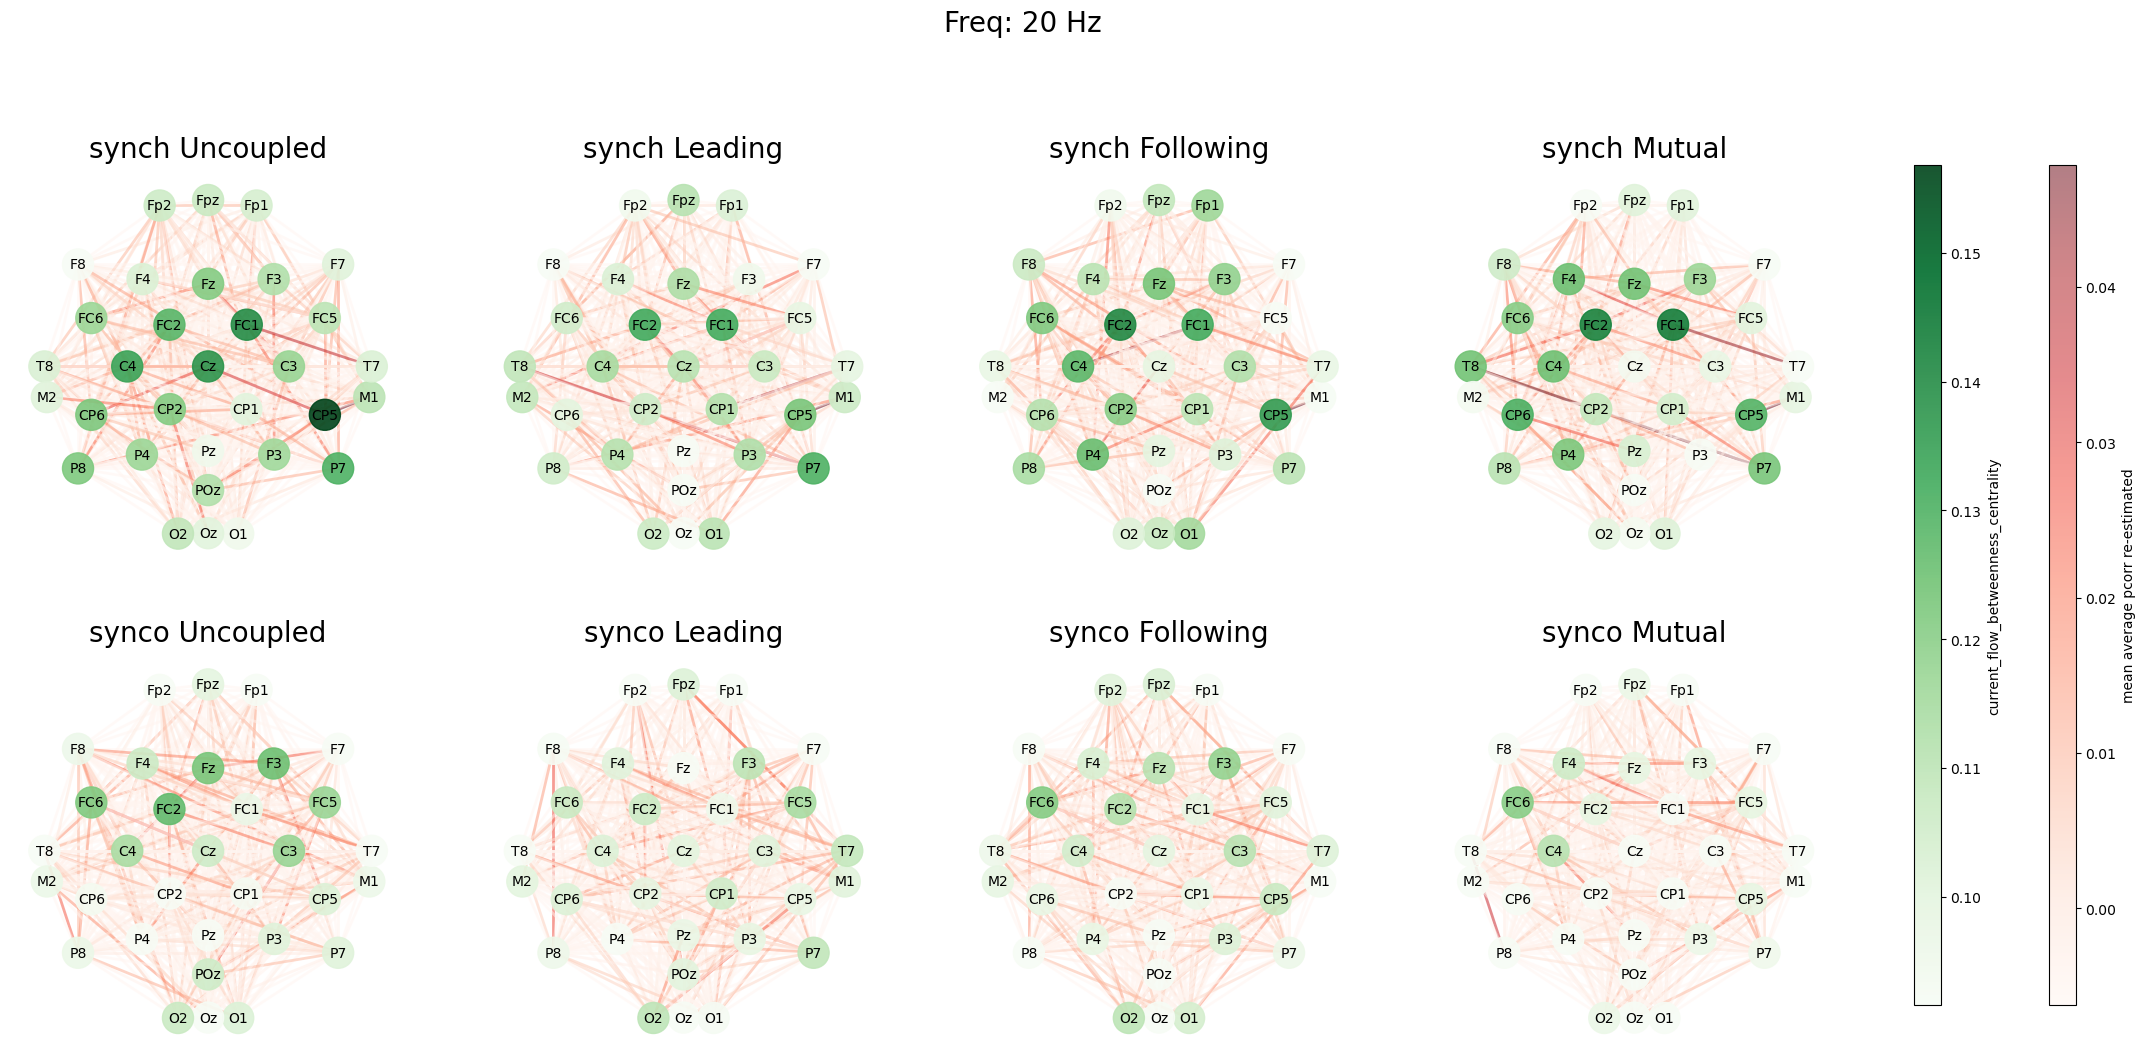

In [7]:
# select a freq to investigate
for freq in [19]: # 5, 9, 19

        fig, ax = plt.subplots(2,4,figsize=(6*4+3, 6*2))

        for syn in range(2):
                for condi in range(4):
                        weights=mean30f_syn_4condi[syn][condi][:,freq]
                        non0_edges=list()
                        for i in range(len(edges_list)): # 496
                                if weights[i] != 0:
                                        non0_edges.append(edges_list[i]+({'weight': weights[i]},))
                        # networkx initiate with edges
                        X = nx.Graph()
                        X.add_edges_from(non0_edges)
                        edges,non0_weights = zip(*nx.get_edge_attributes(X,'weight').items())

                        centrality = nx.current_flow_betweenness_centrality(X, weight='weight')
                        node_colors=[n for n in centrality.values()]

                        # set colorbar limits for node and edge from the 1st subplot
                        if syn==0 and condi ==0:
                                vmin_node_c=min(node_colors)#+0.9*(max(node_colors)-min(node_colors))
                                vmax_node_c=max(node_colors)#-0.45*(max(node_colors)-min(node_colors))
                                vmin_edge_c=min(weights) +0.85*(max(weights)-min(weights))
                                vmax_edge_c=max(weights) -0.05*(max(weights)-min(weights))
                        
                        # subplot
                        plt.sca(ax[syn, condi])

                        nx.draw_networkx_labels(X, pos, labels=labeldict, font_size=10)

                        nodes=nx.draw_networkx_nodes(X, pos, node_size=500, 
                                node_color=node_colors, vmin=vmin_node_c, vmax=vmax_node_c, 
                                cmap='Greens', alpha=0.9)

                        edges=nx.draw_networkx_edges(X, pos, width=2, 
                                edge_color=non0_weights,edge_vmin=vmin_edge_c,edge_vmax=vmax_edge_c,
                                edge_cmap=plt.cm.Reds,alpha=0.5)
                        
                        ax[syn, condi].set_title(syn2names[syn] + ' ' + states4names[condi],
                                                fontsize = 20) 
                        ax[syn, condi].axis('off')

        fig.subplots_adjust(right=0.8)
        cbar_ax1 = fig.add_axes([0.83, 0.15, 0.01, 0.7])
        cbar_ax2 = fig.add_axes([0.88, 0.15, 0.01, 0.7])

        cbar_node=fig.colorbar(nodes,cbar_ax1)
        cbar_node.ax.tick_params(labelsize=10)
        cbar_node.set_label('current_flow_betweenness_centrality')

        cbar_edges=fig.colorbar(edges,cbar_ax2)
        cbar_edges.ax.tick_params(labelsize=10)
        cbar_edges.set_label('mean average pcorr re-estimated')

        fig.subplots_adjust(top=0.85)
        fig.suptitle('Freq: ' + str(freq+1) + ' Hz', fontsize = 20) 


# # print into Pdf file
# paffilename = "freq30_pcorr_networkx.pdf"
# save_image(paffilename)

